# Document Classification with BERT

This notebook presents a simple document classification procedure using a pre-trained BERT model.

Overview of the notebook:

* Loading BERT model & BERT tokenization - we use the `transformers` library from `huggingface` to load a 'bert-base-uncased' model with pre-trained weights. We then utilize appropriate tokenization functions from the same library
* Model definition and forward function - we create a PyTorch model with the BERT, Embedding and Linear layers, with CrossEntropy on top of that
* Training - again from `huggingface`, we'll use a Trainer instance to automate this process and enable simple reporting to `wandb.ai`
* Test Set Evaluation - we evaluate our model on the test set, using the same trainer instance from the previous section
* Report of results - at the end, we present a confusion matrix for predictions on the test set

First - imports, CUDA setup and `wandb` login

In [ ]:
from transformers import BertTokenizer, BertModel, TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy

from torch.utils.data import Dataset
import torch.nn as nn
import torch

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import wandb

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
wandb.login()

wandb: Currently logged in as: radswn. Use `wandb login --relogin` to force relogin


True

## Loading BERT model & BERT tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained(
    'bert-base-uncased',
    output_attentions=False,
    output_hidden_states=False
).to(device)

We will be using a subset of the `HumSet` [dataset](https://blog.thedeep.io/humset/), created by the [DEEP](https://www.thedeep.io) project – an open source platform which aims to facilitate processing of textual data for international humanitarian response organizations. The platform enables the classification of text excerpts, extracted from news and reports into a set of domain specific classes. The provided dataset contains the classes (labels) referring to the humanitarian sectors like agriculture, health, and protection. The dataset contains an overall number of 17,301 data points.

In [ ]:
data_train = pd.read_csv('./data/thedeep.subset.train.txt', header=None, usecols=[1, 2], names=['text', 'label'])
data_validation = pd.read_csv('./data/thedeep.subset.validation.txt', header=None, usecols=[1, 2], names=['text', 'label'])
data_test = pd.read_csv('./data/thedeep.subset.test.txt', header=None, usecols=[1, 2], names=['text', 'label'])
label_names = pd.read_csv('./data/thedeep.labels.txt', header=None, names=['id', 'name'])

Let's plot the document length, so we can decide on the `max_document_length` for the tokenizer

<AxesSubplot: >

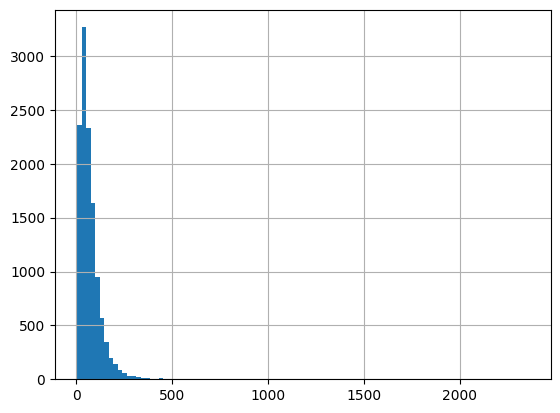

In [ ]:
data_train['text'].apply(lambda x: len(x.split())).hist(bins=100)

Let's perform tokenization. We'll be using padding and truncation so that every sample is of size 512.

In [ ]:
max_document_length = 512
tokens_train = tokenizer(data_train['text'].tolist(), padding='max_length', max_length=max_document_length, truncation=True, return_tensors='pt')
tokens_validation = tokenizer(data_validation['text'].tolist(), padding='max_length', max_length=max_document_length, truncation=True, return_tensors='pt')
tokens_test = tokenizer(data_test['text'].tolist(), padding='max_length', max_length=max_document_length, truncation=True, return_tensors='pt')

Let's not forget about the samples' labels. We'll convert them to lists so that it's easier to compute loss later on.

In [ ]:
labels_train = torch.tensor(data_train['label'].tolist())
labels_validation = torch.tensor(data_validation['label'].tolist())
labels_test = torch.tensor(data_test['label'].tolist())

A simple, custom `torch.data.utils.Dataset` class for out `DataLoader`. In the `__getitem__` we return everything necessary for the future model's forward and backward pass.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, tokens_dict, labels: torch.Tensor):
        self.input_ids = tokens_dict.input_ids
        self.attention_mask = tokens_dict.attention_mask
        self.token_type_ids = tokens_dict.token_type_ids
        self.y = labels

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return {
            'input_ids': self.input_ids[i],
            'attention_mask': self.attention_mask[i],
            'token_type_ids': self.token_type_ids[i],
            'labels': self.y[i]
        }

We create our datasets and set `batch_size` to 16.

In [ ]:
train_dataset = TextDataset(tokens_train, labels_train)
validation_dataset = TextDataset(tokens_validation, labels_validation)
test_dataset = TextDataset(tokens_test, labels_test)

batch_size = 16

## Model definition & forward function

Here we define our model. We take the BERT pre-trained model and assign it as a parameter. We put the `Linear` layer on top of it with `in_features` equal to BERT's last layer output size and `out_features` equal to the number of classes in our dataset (12). We also _freeze_ BERT parameters, as my GPU is not capable of efficiently training this whole monstrosity with 110M parameters. Also, BERT's parameters are fine as they are - they were already trained for us with much more data, we only want to train our linear _head_ that we put on top of it.

We skip the `Softmax` layer, as our `CrossEntropyLoss` uses it already (softmaxing twice would lead to inefficient training).

In the `forward` function, we get the last hidden state from BERT, then we apply our expanded attention mask, so that only embeddings of actual document words are left. We take the mean of it and pass it to the linear layer. We take `argmax` of the logits to get predictions, which are necessary to compute our additional metrics.

In [ ]:
class ClassificationBERTModel(nn.Module):
    def __init__(self, bert_model: BertModel):
        super(ClassificationBERTModel, self).__init__()
        self.bert = bert_model
        self.linear = nn.Linear(768, 12)
        self.loss = nn.CrossEntropyLoss()

        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).last_hidden_state
        attention = attention_mask.unsqueeze(2).expand(-1, -1, 768)
        x = x * attention
        x = x.sum(1)/(x != 0).sum(1)
        x = self.linear(x)

        return self.loss(x, labels), x

## Training

We will use `huggingface` Trainer instance, with training arguments defined as below.

All the optimizing stuff is taken default from the Trainer, specifically:
* Optimizer: AdamW(beta1=0.9, beta2=0.999, epsilon=1e-08)
* LearningRateScheduler: Linear
* Early stopping: whenever there are 2 consecutive epochs of decreasing accuracy score

The outputs will be then reported to the `wandb` dashboard.

In [ ]:
training_args = TrainingArguments(
    output_dir='ClassificationBERT',
    learning_rate=1e-3,
    evaluation_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    logging_strategy=IntervalStrategy.EPOCH,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    num_train_epochs=20,
    report_to=['wandb']
)

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = pred.argmax(1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
trainer = Trainer(
    model=ClassificationBERTModel(bert_model).to(device),
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    args=training_args
)

In [ ]:
trainer.train()

## Test & validation set evaluation

In [ ]:
eval_result = trainer.predict(validation_dataset)
test_result = trainer.predict(test_dataset)

In [ ]:
eval_pred = eval_result.predictions.argmax(1)
test_pred = test_result.predictions.argmax(1)

In [ ]:
eval_metrics = eval_result.metrics
test_metrics = test_result.metrics

## Reporting

[wandb dashboard](https://wandb.ai/radswn/huggingface)

In [ ]:
report_table = pd.DataFrame([eval_metrics, test_metrics], index=['validation', 'test'])
report_table.columns = [c[5:] for c in report_table.columns]

In [ ]:
report_table

,loss,accuracy,precision,recall,f1,runtime,samples_per_second,steps_per_second
validation,0.747993,0.783898,0.698936,0.627699,0.65476,80.3958,32.290,2.027
test,0.751320,0.784586,0.687349,0.620998,0.64271,82.8054,31.339,1.968


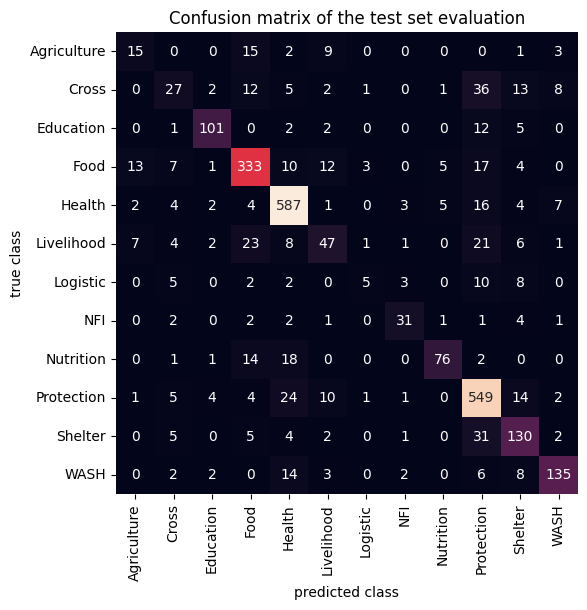

In [ ]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(labels_test, test_pred)
sn.heatmap(conf_matrix, annot=True, annot_kws={'size': 10}, fmt='d', cbar=False, square=True, xticklabels=label_names.name, yticklabels=label_names.name)

plt.title('Confusion matrix of the test set evaluation')
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.show()